# Spectral Analysis

### Libraries Import

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import sys
import os

# Addong parent directory to path
sys.path.append(os.path.abspath('..'))

from src.processing import compute_band_power

# Loading configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Extracting convenient variables
srate = config['signal_generation']['srate']
freq_bands = config['freq_bands']
channels = config['signal_generation']['channels']

print("Config loaded successfully.")
print(f"Bands to extract: {list(freq_bands.keys())}")

Config loaded successfully.
Bands to extract: ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']


### Loading the Raw Data

In [133]:
load_dir = '../data/01_raw'
X_raw = np.load(f'{load_dir}/dataset.npy')
y_labels = np.load(f'{load_dir}/labels.npy')

n_trials, n_channels, n_samples = X_raw.shape
print(f"Loaded Raw Data: {X_raw.shape}")

Loaded Raw Data: (20, 2, 15000)


### Signal Processing Loop

In [134]:
features_list = []

print("Spectral Analysis...")

for i in range(n_trials):
    trial_features = []
    
    # Processing each channel
    for channel_idx in range(n_channels):
        signal = X_raw[i, channel_idx, :]
        
        # Computing band power
        power_matrix = compute_band_power(signal, srate, freq_bands)
        trial_features.append(power_matrix)
        
    # Stacking channels together:
    trial_matrix = np.vstack(trial_features)
    
    # Ensuring that time is the first dimension
    trial_matrix = trial_matrix.T 
    
    features_list.append(trial_matrix)

# Array Conversion
X_features = np.array(features_list)

# Tensor Shape: (Trials, Windows, Features)
print(f"Feature Tensor Shape: {X_features.shape}")

Spectral Analysis...
Feature Tensor Shape: (20, 61, 10)


### Event-Related Spectral Perturbation

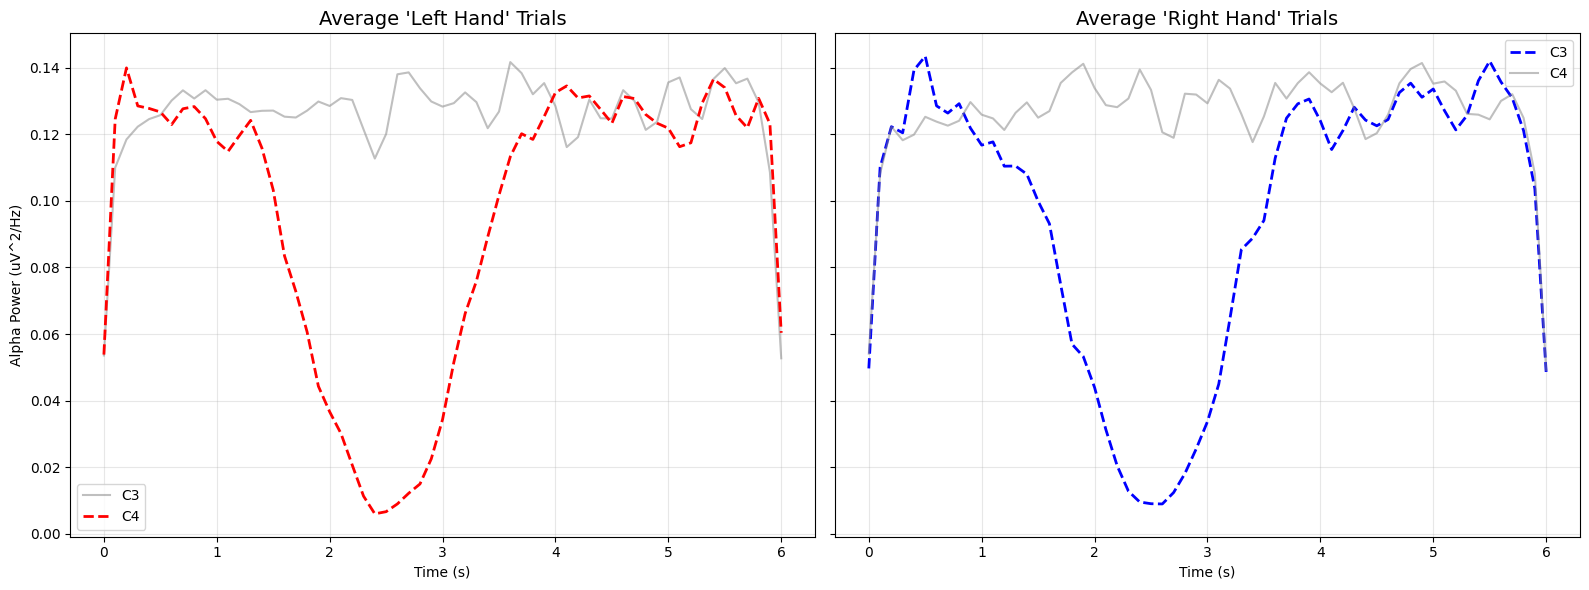

In [135]:
# Identifying indices for each condition
left_idxs = np.where(y_labels == 'Left')[0]
right_idxs = np.where(y_labels == 'Right')[0]

# Computing average power across trials
mean_left = np.mean(X_features[left_idxs, :, :], axis=0)
mean_right = np.mean(X_features[right_idxs, :, :], axis=0)

# Feature indices
alpha_c3 = 2
alpha_c4 = 7

# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
time_axis = np.linspace(0, 6, X_features.shape[1])

# Left hand movement
ax = axes[0]
ax.set_title(f"Average 'Left Hand' Trials", fontsize=14)

# C3 is idle
ax.plot(time_axis, mean_left[:, alpha_c3], color='gray', alpha=0.5, lw=1.5, label='C3')
# C4 is active
ax.plot(time_axis, mean_left[:, alpha_c4], color='red', lw=2, linestyle='--', label='C4')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Alpha Power (uV^2/Hz)')
ax.legend()
ax.grid(True, alpha=0.3)


# Right hand movement
ax = axes[1]
ax.set_title(f"Average 'Right Hand' Trials", fontsize=14)

# C3 is active
ax.plot(time_axis, mean_right[:, alpha_c3], color='blue', lw=2, linestyle='--', label='C3')
# C4 is idle
ax.plot(time_axis, mean_right[:, alpha_c4], color='gray', alpha=0.5, lw=1.5, label='C4')

ax.set_xlabel('Time (s)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Saving Features Data

In [136]:
save_dir = '../data/02_features'
os.makedirs(save_dir, exist_ok=True)

np.save(f'{save_dir}/features.npy', X_features)
np.save(f'{save_dir}/labels.npy', y_labels)

print(f"Features Data saved to {save_dir}")

Features Data saved to ../data/02_features
